

# **Introduction to the code**




***Below is the code implementing a Federated approach for a multiple linear regression model using the California Housing dataset. We have created a custom Regressor class that utilizes Stochastic Gradient Descent as its optimizer. Additionally, we have created a Federated class that acts as the server unit, collecting weights and biases from individual clients to produce new weight and bias.***

***More on the Federated Class:***

***The Federated class takes in several inputs including a global model, a local model, the number of cycles for training, the number of clients, and the x and y data. The class then splits the x and y data among the clients and trains the local model on each client's data. The local models are then aggregated to update the global model. The process is repeated for a specified number of cycles.***

***The "fed_learn" method is responsible for iterating through the cycles, training the local models, and aggregating the global model. The "client_data_split" method is used to divide the input and output data among the clients. The code also keeps track of the mean squared error (MSE) for each cycle and stores it in a list. The final output of the Federated class is the trained global model, the list of MSE values, and a list of the cycle numbers.***

***Finally, we compare our results with the results produced by scikit-learn functions for the same dataset.***

***Importing Required Libraries***

In [68]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.cluster import DBSCAN
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

***importing the data and converting it to a Pandas DataFrame***

In [ ]:
path= "./USA_Housing.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
df  = pd.read_csv(path)

# ***DATA ANALYSIS AND PREPROCESS***

In [71]:
df.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05,USNS Raymond\nFPO AE 09386


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg. Area Income              5000 non-null   float64
 1   Avg. Area House Age           5000 non-null   float64
 2   Avg. Area Number of Rooms     5000 non-null   float64
 3   Avg. Area Number of Bedrooms  5000 non-null   float64
 4   Area Population               5000 non-null   float64
 5   Price                         5000 non-null   float64
 6   Address                       5000 non-null   object 
dtypes: float64(6), object(1)
memory usage: 273.6+ KB


***Checking for Null Values***

In [73]:
df.isnull().sum()

,0
Avg. Area Income,0
Avg. Area House Age,0
Avg. Area Number of Rooms,0
Avg. Area Number of Bedrooms,0
Area Population,0
Price,0
Address,0


***Dropping irrelevant Data***

In [74]:
# df = df.drop('longitude',axis = 1)
# df = df.drop('latitude',axis = 1)
df = df.drop('Address',axis = 1)

In [75]:
df

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05
...,...,...,...,...,...,...
4995,60567.944140,7.830362,6.137356,3.46,22837.361035,1.060194e+06
4996,78491.275435,6.999135,6.576763,4.02,25616.115489,1.482618e+06
4997,63390.686886,7.250591,4.805081,2.13,33266.145490,1.030730e+06
4998,68001.331235,5.534388,7.130144,5.44,42625.620156,1.198657e+06


***Obtaining basic statistical information of the data***

In [76]:
df.describe()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03
mean,68583.108984,5.977222,6.987792,3.981330,36163.516039,1.232073e+06
std,10657.991214,0.991456,1.005833,1.234137,9925.650114,3.531176e+05
min,17796.631190,2.644304,3.236194,2.000000,172.610686,1.593866e+04
25%,61480.562388,5.322283,6.299250,3.140000,29403.928702,9.975771e+05
50%,68804.286404,5.970429,7.002902,4.050000,36199.406689,1.232669e+06
75%,75783.338666,6.650808,7.665871,4.490000,42861.290769,1.471210e+06
max,107701.748378,9.519088,10.759588,6.500000,69621.713378,2.469066e+06


***Replacing null values with the mean of the respective feature***

In [77]:
# mean_bedroom = df['total_bedrooms'].mean()
# df['total_bedrooms'].fillna(mean_bedroom, inplace=True)

***Plotting the distribution of the target data***

<Axes: >

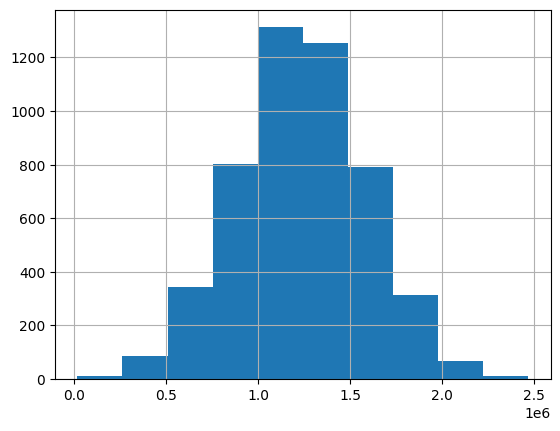

In [78]:
df['Price'].hist()

***Plotting the distribution of all the features***

In [79]:
features = list(df.columns)

array([[<Axes: title={'center': 'Avg. Area Income'}>,
        <Axes: title={'center': 'Avg. Area House Age'}>],
       [<Axes: title={'center': 'Avg. Area Number of Rooms'}>,
        <Axes: title={'center': 'Avg. Area Number of Bedrooms'}>],
       [<Axes: title={'center': 'Area Population'}>,
        <Axes: title={'center': 'Price'}>]], dtype=object)

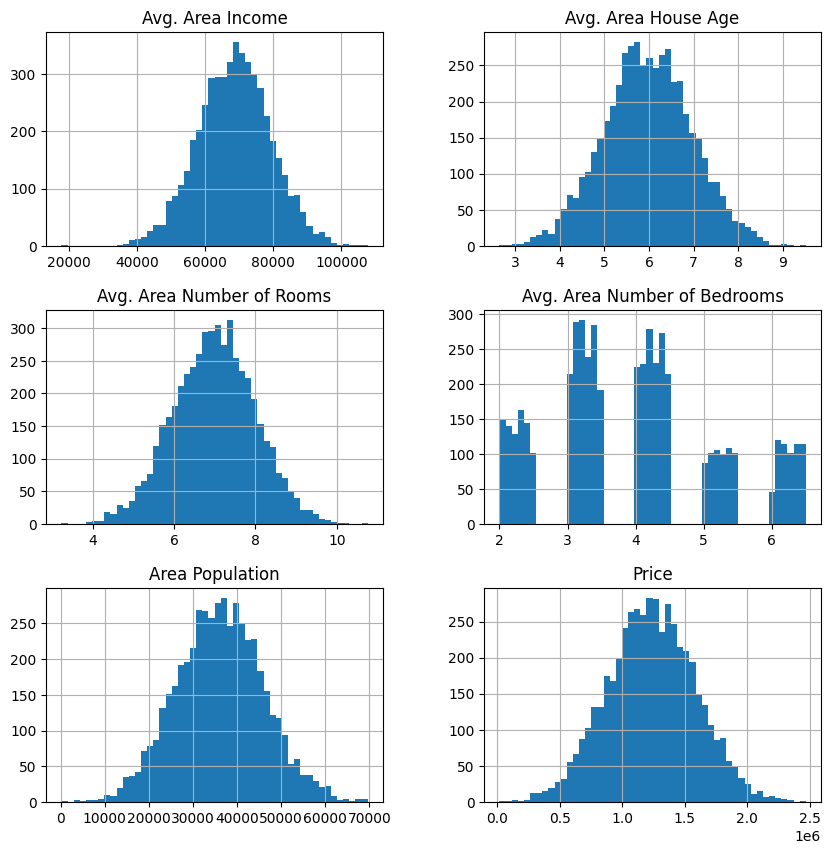

In [80]:
df[features].hist(bins=50, figsize=(10, 10))

***Plotting to visualize the outliers in the data***

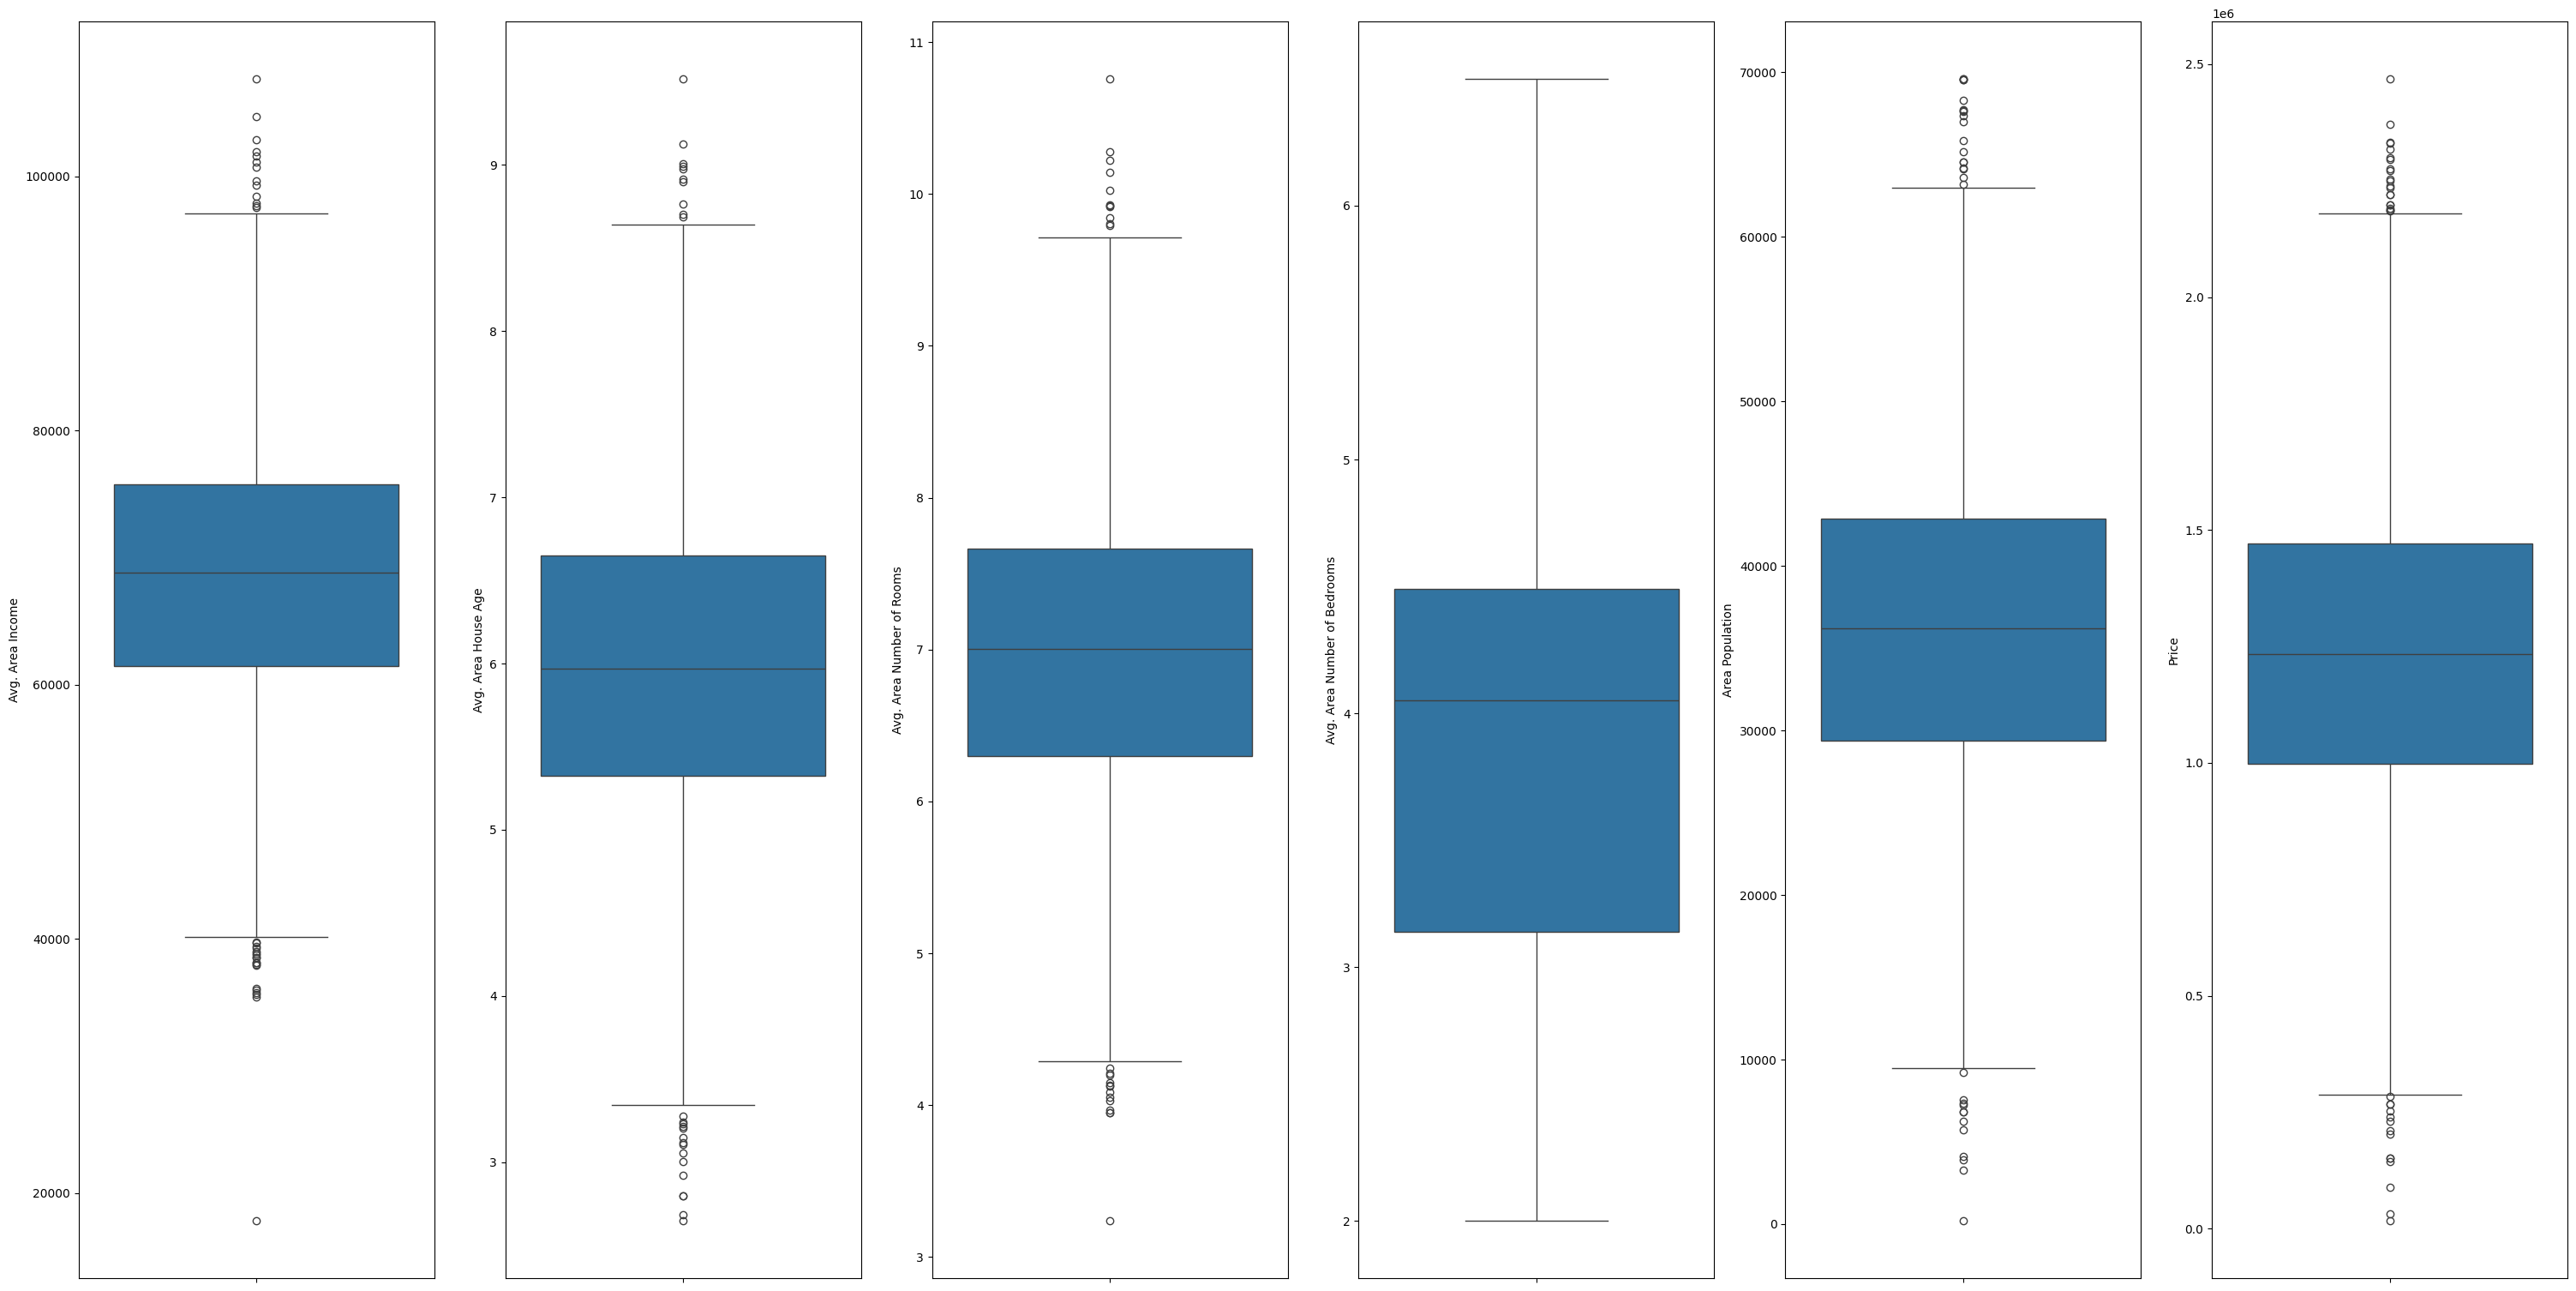

In [81]:
df_rows = 1
df_cols = 6

fig, ax = plt.subplots(nrows = df_rows, ncols=df_cols, figsize = (30,15) )
index=0
ax= ax.flatten()
for col,value in df.items():
    sb.boxplot(data = df, y= col, ax = ax[index])
    index += 1
plt.tight_layout(pad = 0.5,w_pad =0.7 , h_pad =5)

***Finding the correlation matrix of the data***

In [82]:
df_corr = df.corr()
df_corr

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
Avg. Area Income,1.000000,-0.002007,-0.011032,0.019788,-0.016234,0.639734
Avg. Area House Age,-0.002007,1.000000,-0.009428,0.006149,-0.018743,0.452543
Avg. Area Number of Rooms,-0.011032,-0.009428,1.000000,0.462695,0.002040,0.335664
Avg. Area Number of Bedrooms,0.019788,0.006149,0.462695,1.000000,-0.022168,0.171071
Area Population,-0.016234,-0.018743,0.002040,-0.022168,1.000000,0.408556
Price,0.639734,0.452543,0.335664,0.171071,0.408556,1.000000


***finding outliers***

In [83]:


feature_name = 'Avg. Area Income'

Q1 = df[feature_name].quantile(0.25)
Q3 = df[feature_name].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)


lower_outliers = df[df[feature_name] < lower_bound]
upper_outliers = df[df[feature_name] > upper_bound]


lower_outliers_avg = lower_outliers[feature_name].mean()

upper_outliers_avg = upper_outliers[feature_name].mean()


print("Average of lower bound outliers:", lower_outliers_avg)
print("Average of upper bound outliers:", upper_outliers_avg)


Average of lower bound outliers: 36880.998756109846
Average of upper bound outliers: 100862.59978791366


In [84]:
feature_name = 'Avg. Area Income'

Q1 = df[feature_name].quantile(0.25)
Q3 = df[feature_name].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

lower_outliers = df[df[feature_name] < lower_bound]
upper_outliers = df[df[feature_name] > upper_bound]

outliers_array_low = lower_outliers[feature_name].values
outliers_array_up = upper_outliers[feature_name].values

normalized_outliers_up = 1.2 * (outliers_array_up - np.mean(outliers_array_up)) / np.std(outliers_array_up)
normalized_outliers_low = -1.2 * (outliers_array_low - np.mean(outliers_array_low)) / np.std(outliers_array_low)

selected_value_up = np.random.choice(normalized_outliers_up)
selected_value_low = np.random.choice(normalized_outliers_low)

print("\n Outlier upper value:", selected_value_up)
print("\n Outlier lower value:", selected_value_low)


 Outlier upper value: 0.11779402224561235

 Outlier lower value: 0.23372698554499916


***Storing the dependent data in the y variable***

In [85]:
y = np.asarray(df['Price'].values.tolist())

***Droppping the dependent data from the main dataframe***

In [86]:
df1 = df.drop('Price',axis = 1)

***Storing the independent data in the x variable***

In [87]:
x = np.asarray(df1.values.tolist())

***Reshaping the y variable for matrix operations in prediction calculations***

In [88]:
y = y.reshape(len(y),1)

In [89]:
x.shape

(5000, 5)

In [90]:
y.shape

(5000, 1)

***Standardizing the x and y data***

In [91]:
y_mean = np.mean(y,axis = 0)
y_std = np.std(y,axis = 0)

In [92]:
x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)

In [93]:
y = (y - np.mean(y, axis=0)) / np.std(y, axis=0)

***Adding a coloumn of ones to the numpy array for the Bias term***

In [94]:
x = np.hstack((np.ones((x.shape[0], 1)), x))

***Splitting the Data test into train set test set***

In [95]:
def split_data(X, y, test_size=0.2, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test


In [96]:
X_train, X_test, y_train, y_test = split_data(x, y, test_size=0.2)

***Declaring initial weight and Bias***

In [97]:
num_features = X_train.shape[1]
w = np.ones((num_features, 1))
b = 0

# **Multiple Linear Regression Class using SGD as an optimizer**

In [98]:
class Regressor:
    def __init__(self, w, b,batch_size, learning_rate, num_epochs):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.w = w
        self.b = b
        self.mse_values = None
        self.epoch_values = None

    def train(self, X, y):

        self.mse_values = []
        self.epoch_values = []
        self.batch_msevalues = []
        self.batch_epoch_values = []

        for epoch in range(self.num_epochs):

            indices = np.random.permutation(len(X))
            X_shuffled, y_shuffled = X[indices], y[indices]

            num_batches = len(X) // self.batch_size
            if len(X) % self.batch_size != 0:
                num_batches += 1

            random_batch_index = random.randint(0, num_batches - 1)

            start = random_batch_index * self.batch_size
            end = start + self.batch_size
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            y_pred = self.predict(X_batch)
            error = y_batch - y_pred

            mse = np.mean(error ** 2)
            self.batch_msevalues.append(mse)
            self.batch_epoch_values.append(epoch)

            dw = -(2 / self.batch_size) * np.dot(X_batch.T, error)
            db = -(2 / self.batch_size) * np.sum(error)

            self.w = self.w - self.learning_rate * dw
            self.b = self.b - self.learning_rate * db

            self.mse_values.append(mse)
            self.epoch_values.append(epoch)

        return (
            self.w,
            self.b,
            self.mse_values,
            self.epoch_values,
            self.batch_epoch_values,
            self.batch_msevalues,
        )

    def test(self, X, y):
        y_pred = self.predict(X)
        mse = np.mean((y - y_pred)**2)
        return mse

    def predict(self, X):
        y_pred = np.dot(X, self.w) + self.b
        return y_pred


***Function for calculating the r squared values***

In [99]:
def r2_sgd(regressor, x, y):

    y_pred = regressor.predict(x)
    y_mean = np.mean(y)
    tss = np.sum((y - y_mean)**2)
    rss = np.sum((y - y_pred)**2)
    r2 = 1 - (rss / tss)

    return r2


***Declaring an Object of Regressor class and calling the train function***

In [100]:
reg = Regressor(w, b,500,0.1,50)

w1, b1, mse_values, epoch_values,batch_epoch_values, batch_msevalues = reg.train(X_train, y_train)

***The Mean Squared Error Value of reg object***

In [101]:
mse = reg.test(X_test,y_test)
mse

np.float64(0.08207446240547264)

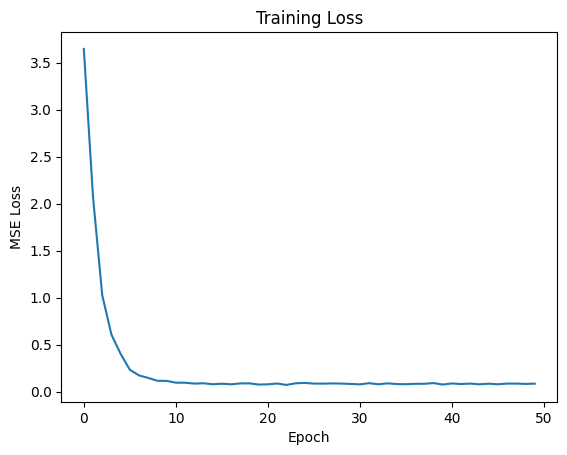

In [102]:
plt.plot(epoch_values, mse_values)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

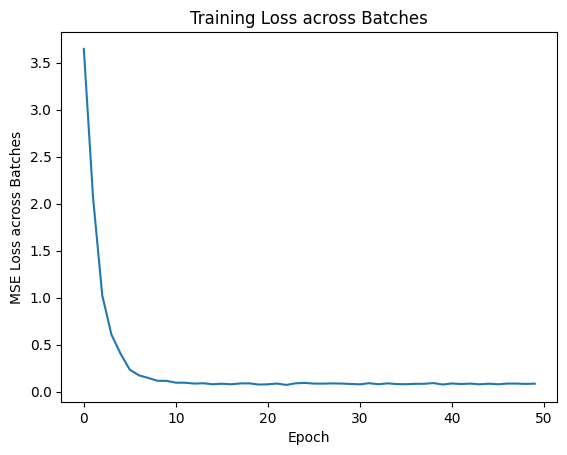

In [103]:
plt.plot(batch_epoch_values, batch_msevalues)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss across Batches')
plt.title('Training Loss across Batches')
plt.show()


***R2 value of the reg object***

In [104]:
r2 = r2_sgd(reg, X_test, y_test)
r2_train = r2_sgd(reg,X_train,y_train)
print(f'R-squared value: {r2:.4f}')
# print(f'R-squared value: {r2_train:.4f}')

R-squared value: 0.9166


#**Federated approach of multiple linear regression**

***Declaring the hyperparameters for Federated Model***

In [105]:
local_batch = 10
epoch = 20
learning_rate = 0.001
n_clients = 10
cycles = 75

enable_noise=False
client_index=2
feature_index=1
noise_value= 5
change_percentage=0.5

***Declaring the global_object (as Server unit) and Local objects (as Mobile Devices)***

In [106]:
local_model = Regressor(w,b,local_batch,learning_rate,epoch)
global_model = Regressor(w,b,0,0,0)

***Federated Class***

In [107]:
class Federated:
    def __init__(self, global_model, local_model, cycles, n_clients, X, y, enable_noise=False,
                 client_index=None, feature_index=None, noise_value=None, change_percentage=None):
        self.n_clients = n_clients
        self.X = X
        self.y = y
        self.local_model = local_model
        self.global_model = global_model
        self.cycles = cycles
        self.enable_noise = enable_noise
        self.client_index = client_index
        self.feature_index = feature_index
        self.noise_value = noise_value
        self.change_percentage = change_percentage
        self.client_metrics_log = []  # Add this to store client metrics

    def fed_learn(self, X_test, y_test):  # Added X_test, y_test parameters which were missing
        client_data, client_targets = self.client_data_split()
        self.mse_list = []
        self.cycles_list = []
        self.client_contributions = []  # Track client contributions across cycles

        for cycle_idx in range(self.cycles):
            cycle_contributions = []  # Track contributions for this cycle

            # Reset local model to global model parameters
            self.local_model.w = self.global_model.w.copy()  # Use copy() to avoid reference issues
            self.local_model.b = self.global_model.b

            client_weights = []  # Store each client's weights
            client_biases = []   # Store each client's biases

            # First, train all clients and evaluate their contributions
            for client_idx in range(self.n_clients):
                # Train the local model on client data
                self.local_model.train(client_data[client_idx], client_targets[client_idx])

                # Evaluate this client's contribution
                contribution = self.evaluate_client_contribution(
                    self.local_model, client_data[client_idx], client_targets[client_idx])
                cycle_contributions.append(contribution)

                # Store trained weights and biases
                client_weights.append(self.local_model.w.copy())
                client_biases.append(self.local_model.b)

                # Reset local model for next client
                if client_idx < self.n_clients - 1:
                    self.local_model.w = self.global_model.w.copy()
                    self.local_model.b = self.global_model.b

            # Store all client contributions for this cycle
            self.client_contributions.append(cycle_contributions)

            # Now aggregate all client models to update global model
            # Simple average aggregation (can be modified to use contribution scores)
            self.global_model.w = np.mean(client_weights, axis=0)
            self.global_model.b = np.mean(client_biases)

            # Evaluate global model
            mse_global = self.global_model.test(X_test, y_test)
            self.mse_list.append(mse_global)
            self.cycles_list.append(cycle_idx)

            print(f"Cycle {cycle_idx+1}/{self.cycles}, Global MSE: {mse_global:.4f}")
            print(f"Client contributions: {[f'{c:.4f}' for c in cycle_contributions]}")

        return self.global_model, self.mse_list, self.cycles_list, self.client_contributions

    def client_data_split(self):
        client_d = np.array_split(self.X, self.n_clients)
        client_t = np.array_split(self.y, self.n_clients)
        return client_d, client_t

    def evaluate_client_contribution(self, model, X, y):
        """
        Evaluates the contribution quality of a client's model update.

        This function calculates multiple metrics to assess how valuable a client's
        model update is to the federation. It considers both performance on the client's
        local data and the magnitude of parameter updates.

        Parameters:
        -----------
        model : object
            The local model that has been trained on the client's data
        X : numpy.ndarray
            Features of the client's dataset
        y : numpy.ndarray
            Target values of the client's dataset

        Returns:
        --------
        float
            A contribution score where higher values indicate better contribution
        """
        # Calculate prediction error on client's own data
        y_pred = model.predict(X)
        mse = np.mean((y_pred - y) ** 2)

        # Calculate R-squared (coefficient of determination)
        # R-squared measures how well the model explains the variance in the data
        y_mean = np.mean(y)
        ss_total = np.sum((y - y_mean) ** 2)
        ss_residual = np.sum((y - y_pred) ** 2)
        r_squared = 1 - (ss_residual / (ss_total + 1e-10))

        # Calculate parameter update magnitude
        # This measures how much the client's model parameters changed during training
        param_change_magnitude = np.linalg.norm(model.w - self.global_model.w)

        # Penalize extremely large parameter changes as they may indicate overfitting
        # or adversarial updates
        update_penalty = 1.0 / (1.0 + 0.1 * param_change_magnitude)

        # Calculate data diversity score
        # Higher variance in features indicates more diverse data
        feature_variance = np.mean(np.var(X, axis=0))
        diversity_score = np.tanh(feature_variance)  # Normalize to 0-1 range

        # Combine metrics into a single score
        # We can adjust these weights based on what aspects we want to emphasize
        score_weights = {
            'mse': 0.5,        # Emphasize prediction accuracy
            'r_squared': 0.2,  # Consider fit quality
            'update': 0.2,     # Consider parameter update quality
            'diversity': 0.1   # Consider data diversity
        }

        # Calculate weighted score (negative MSE so higher values are better)
        contribution_score = (
            score_weights['mse'] * (-mse) +
            score_weights['r_squared'] * r_squared +
            score_weights['update'] * update_penalty +
            score_weights['diversity'] * diversity_score
        )

        # Log detailed metrics for research analysis
        if hasattr(self, 'client_metrics_log'):
            self.client_metrics_log.append({
                'client_id': len(X),  # Use data size as proxy for client ID
                'mse': mse,
                'r_squared': r_squared,
                'param_change': param_change_magnitude,
                'diversity': diversity_score,
                'final_score': contribution_score
            })

        return contribution_score

    def visualize_client_contributions(self):
        """
        Visualizes the contribution of each client over training cycles.
        """
        import matplotlib.pyplot as plt

        if not hasattr(self, 'client_contributions') or not self.client_contributions:
            print("No client contribution data available.")
            return

        plt.figure(figsize=(10, 6))
        cycles = range(1, len(self.client_contributions) + 1)

        # Plot each client's contribution over cycles
        for client_idx in range(self.n_clients):
            client_scores = [self.client_contributions[cycle][client_idx]
                            for cycle in range(len(self.client_contributions))]
            plt.plot(cycles, client_scores, marker='o', label=f'Client {client_idx+1}')

        plt.xlabel('Cycle')
        plt.ylabel('Contribution Score')
        plt.title('Client Contribution Scores Over Training Cycles')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Also plot the global model MSE
        plt.figure(figsize=(10, 6))
        plt.plot(cycles, self.mse_list, marker='s', color='red', linewidth=2)
        plt.xlabel('Cycle')
        plt.ylabel('Global Model MSE')
        plt.title('Global Model Performance Over Training Cycles')
        plt.grid(True)
        plt.show()

***Declaring an Object of the Federated Class***

In [108]:
# Initialize and run the federated learning process
fed = Federated(global_model, local_model, cycles, n_clients, X_train, y_train,
                enable_noise, client_index, feature_index, noise_value, change_percentage)

# Run federated learning with client contribution evaluation
global_model, mse_list, cycles_list, client_contributions = fed.fed_learn(X_test, y_test)



# Print detailed contribution metrics
print("\nDetailed Client Metrics:")
for i, metric in enumerate(fed.client_metrics_log):
    print(f"Entry {i+1}: {metric}")

Cycle 1/75, Global MSE: 3.1873
Client contributions: ['-1.9929', '-1.9867', '-1.8816', '-1.8021', '-2.0035', '-1.8380', '-1.7511', '-1.8755', '-2.0476', '-2.0379']
Cycle 2/75, Global MSE: 2.8316
Client contributions: ['-1.6741', '-1.6936', '-1.5955', '-1.6033', '-1.7598', '-1.5589', '-1.5119', '-1.6242', '-1.7460', '-1.7640']
Cycle 3/75, Global MSE: 2.5243
Client contributions: ['-1.4637', '-1.4943', '-1.4028', '-1.3389', '-1.5029', '-1.2717', '-1.2577', '-1.4408', '-1.5212', '-1.5338']
Cycle 4/75, Global MSE: 2.2480
Client contributions: ['-1.2329', '-1.2530', '-1.1833', '-1.1272', '-1.3146', '-1.1356', '-1.0856', '-1.1899', '-1.3158', '-1.3029']
Cycle 5/75, Global MSE: 2.0059
Client contributions: ['-1.0625', '-1.0839', '-0.9842', '-0.9694', '-1.1262', '-0.9604', '-0.9224', '-1.0306', '-1.0708', '-1.1097']
Cycle 6/75, Global MSE: 1.7846
Client contributions: ['-0.9007', '-0.9202', '-0.8439', '-0.8042', '-0.9450', '-0.7878', '-0.7700', '-0.8159', '-0.9220', '-0.9423']
Cycle 7/75, Glob

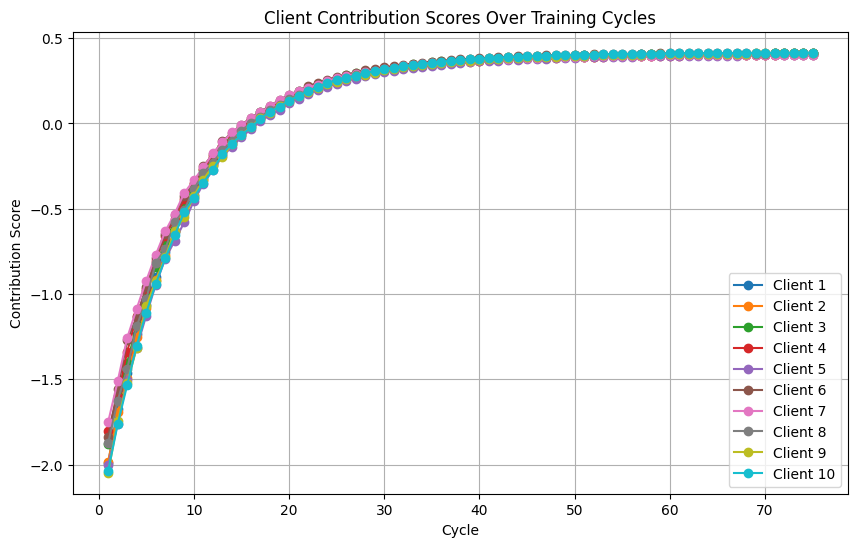

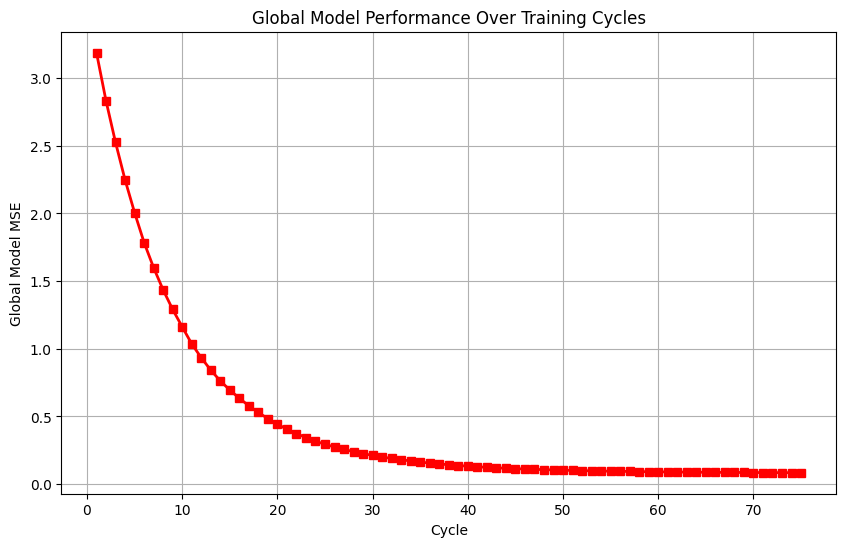

In [109]:
# Visualize the results
fed.visualize_client_contributions()

***Fetching an object called Federated_Model with updated weights and biases from fed_learn function of the Federated Class***

In [110]:
Federated_model, mse_global, cycle_global, client_contributions = fed.fed_learn(X_test, y_test)

Cycle 1/75, Global MSE: 0.0843
Client contributions: ['0.4110', '0.4055', '0.4112', '0.4027', '0.4004', '0.4149', '0.4037', '0.4112', '0.4120', '0.4148']
Cycle 2/75, Global MSE: 0.0841
Client contributions: ['0.4110', '0.4056', '0.4112', '0.4030', '0.4006', '0.4150', '0.4039', '0.4115', '0.4123', '0.4149']
Cycle 3/75, Global MSE: 0.0839
Client contributions: ['0.4111', '0.4058', '0.4113', '0.4030', '0.4008', '0.4151', '0.4039', '0.4116', '0.4124', '0.4150']
Cycle 4/75, Global MSE: 0.0838
Client contributions: ['0.4112', '0.4060', '0.4115', '0.4033', '0.4009', '0.4151', '0.4041', '0.4118', '0.4126', '0.4151']
Cycle 5/75, Global MSE: 0.0836
Client contributions: ['0.4114', '0.4060', '0.4115', '0.4033', '0.4011', '0.4152', '0.4041', '0.4119', '0.4126', '0.4152']
Cycle 6/75, Global MSE: 0.0835
Client contributions: ['0.4114', '0.4062', '0.4116', '0.4033', '0.4012', '0.4152', '0.4043', '0.4121', '0.4129', '0.4153']
Cycle 7/75, Global MSE: 0.0833
Client contributions: ['0.4116', '0.4062', '0

In [111]:
y_p = global_model.predict(X_test)

***Plotting the per cycle mse performance of our updated weight and bias***

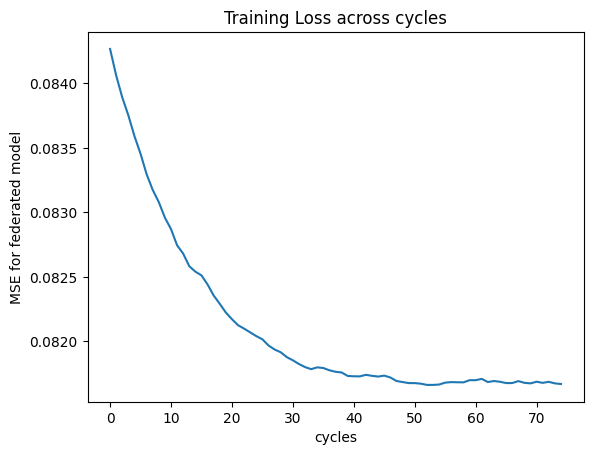

In [112]:
plt.plot(cycle_global, mse_global)
plt.xlabel('cycles')
plt.ylabel('MSE for federated model')
plt.title('Training Loss across cycles')
plt.show()

***MSE of the Federated_Model***

In [113]:
mse = Federated_model.test(X_test,y_test)
mse

np.float64(0.08167041054336528)

***R2 value of the Federated_Model***

In [114]:
r2 = r2_score(y_test, y_p, multioutput='variance_weighted')
print(f'R-squared value of Federated Model: {r2:.4f}')

R-squared value of Federated Model: 0.9170


#***using scikit learn for comparing r2 values***

In [115]:
from sklearn.model_selection import train_test_split
xl_train, xl_test, yl_train, yl_test = train_test_split(x, y, test_size = .20, random_state = 1,)

#SGD LINEAR REGRESSION

***Training the model using SGDRegressor Class of scikit-learn***

In [116]:
from sklearn.linear_model import SGDRegressor
reg =SGDRegressor(max_iter=50, tol=1e-3)
reg.fit(x, y)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(max_iter=50)

In [117]:
ys_p = reg.predict(xl_test)

***Mean Squared Error values of the SGDRegressor class of scikit learn***

In [118]:
mean_squared_error(yl_test, ys_p)

0.08456507394280331

***R2 values of the SGDRegressor class of scikit learn***

In [119]:
from sklearn.metrics import r2_score
print(r2_score(yl_test, ys_p, multioutput='variance_weighted') )
# print(r2_score(yl_train,reg.predict(xl_train), multioutput='variance_weighted'))

0.9216018012343532


# LINEAR REGRESSION GRADIENT DESCENT

***Training the model using LinearRegression Class of scikit-learn***

In [120]:
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(xl_train, yl_train)

LinearRegression()

In [121]:
yl_p = model1.predict(xl_test)

***Mean Squared Error values of the LinearRegression class of scikit learn***

In [122]:
mean_squared_error(yl_test, yl_p)

0.08457400260257629

***R2 values of the LinearRegression class of scikit learn***

In [123]:
from sklearn.metrics import r2_score
print(r2_score(yl_test, yl_p, multioutput='variance_weighted') )
# print(r2_score(yl_train,model1.predict(xl_train), multioutput='variance_weighted'))

0.9215935236936268


In [124]:
print(median_absolute_error(y_test,Federated_model.predict(X_test)))
print(median_absolute_error(y_test,ys_p))

0.19676848296668398
0.9565073307713973


# **Results**





***Comparing predicted values of Federated_Model & sklearn_functions with real values***

In [125]:
def unscale(y,y_pred,y_sk,y_sgd):
  y = (y*y_std)+y_mean
  y_pred = (y_pred*y_std)+y_mean
  y_sk = (y_sk*y_std)+y_mean
  y_sgd = (y_sgd*y_std)+y_mean
  return y,y_pred,y_sk,y_sgd

In [126]:
def compare(Fed_mod,x,y,y_sk,y_sgd,index):
  y_pred = Federated_model.predict(x)
  y,y_pred,y_sk,y_sgd = unscale(y,y_pred,y_sk,y_sgd)
  result = np.column_stack((y,y_pred,y_sk,y_sgd))
  result_df = pd.DataFrame(result,columns = ['Real','Predicted','skl_linear','skl_SGD'])
  print(result_df.iloc[index])


In [127]:
index = 100
compare(Federated_model,X_test,y_test,yl_p,ys_p,index)

Real          1.106337e+06
Predicted     1.007476e+06
skl_linear    6.574497e+05
skl_SGD       6.575890e+05
Name: 100, dtype: float64


***Comparing median absolute error of our Federated_model and SGDRegressor of sklearn library***

# **Comparing number of communicaton cycles to reach a Target r2 score**

In [128]:
n = 100
r2_scores = []

for _ in range(n):
    model2 = LinearRegression()
    model2.fit(X_train, y_train)
    yl_p = model1.predict(X_test)
    tr2 = r2_score(y_test, yl_p, multioutput='variance_weighted')
    r2_scores.append(tr2)
#     print(f"R2 Score: {tr2:.2f}")

average_r2 = np.mean(r2_scores)
print(f"Average R2 Score after {n} iterations: {average_r2:.2f}")

Average R2 Score after 100 iterations: 0.92


In [129]:
# learning_rate = 0.001
# n_clients = 20
# epoch = 10
# local_batch = 20
# cycles = 1

# enable_noise = True
# client_index = 2
# feature_index = 1
# noise_value = 5
# change_percentage = 0.5

# target_r2_score = 0.90

# while True:
#     num_features = X_train.shape[1]
#     w = np.ones((num_features, 1))
#     b = 0
#     local_model1 = Regressor(w, b, local_batch, learning_rate, epoch)
#     global_model1 = Regressor(w, b, 0, 0, 0)
#     fed1 = Federated(global_model1, local_model1, cycles, n_clients, X_train, y_train, enable_noise,
#                      client_index, feature_index, noise_value, change_percentage)
#     Federated_model1, mse_global1, cycle_global1 = fed1.fed_learn()
#     yx_p = global_model1.predict(X_test)
#     r_2x = r2_score(y_test, yx_p, multioutput='variance_weighted')
#     print(f"R2 score after {cycles} cycles: {r_2x}")

#     if r_2x >= target_r2_score:
#         break
#     cycles += 1


In [130]:
r2_score(yl_test, ys_p, multioutput='variance_weighted')
array = np.array([[1, 5, 5, 3219, 1],
                  [10, 5, 5, 127, 24.64],
                  [20, 10, 10, 39, 82.54],
                  [50, 15, 15, 9, 357.67],
                  [100, 20, 20, 3, 1073]])

column_names = ['Client', 'Epoch', 'Batch', 'Cycles', 'SpeedUp']

table = pd.DataFrame(array, columns=column_names)
print("Table 1:\n")
print(table)

array1 = np.array([[5, 35, 1],
                   [10, 35, 1],
                   [15, 36, 1],
                   [20, 36, 1]])

column_names1 = ['Batch', 'Cycles', 'SpeedUp']

table1 = pd.DataFrame(array1, columns=column_names1)
print("\nTable 2:\nLEARNING RATE = 0.001, CLIENTS = 20 , EPOCHS = 10\n")
print(table1)

array2 = np.array([[5, 73, 1],
                   [10, 36, 2],
                   [15, 25, 3],
                   [20, 18, 4]])

column_names2 = ['Epoch', 'Cycles', 'SpeedUp']

table2 = pd.DataFrame(array2, columns=column_names2)
print("\nTable 3:\nLEARNING RATE = 0.001, CLIENTS = 20 , BATCHES = 10\n")
print(table2)

array3 = np.array([[1, 1642, 1],
                   [10, 75, 21],
                   [20, 35, 46],
                   [55, 14, 117],
                   [100, 7, 234]])

column_names3 = ['Clients', 'Cycles', 'SpeedUp']

table3 = pd.DataFrame(array3, columns=column_names3)
print("\nTable 4:\nLEARNING RATE = 0.001, BATCHES = 10 , EPOCHS = 10\n")
print(table3)

Table 1:

   Client  Epoch  Batch  Cycles  SpeedUp
0     1.0    5.0    5.0  3219.0     1.00
1    10.0    5.0    5.0   127.0    24.64
2    20.0   10.0   10.0    39.0    82.54
3    50.0   15.0   15.0     9.0   357.67
4   100.0   20.0   20.0     3.0  1073.00

Table 2:
LEARNING RATE = 0.001, CLIENTS = 20 , EPOCHS = 10

   Batch  Cycles  SpeedUp
0      5      35        1
1     10      35        1
2     15      36        1
3     20      36        1

Table 3:
LEARNING RATE = 0.001, CLIENTS = 20 , BATCHES = 10

   Epoch  Cycles  SpeedUp
0      5      73        1
1     10      36        2
2     15      25        3
3     20      18        4

Table 4:
LEARNING RATE = 0.001, BATCHES = 10 , EPOCHS = 10

   Clients  Cycles  SpeedUp
0        1    1642        1
1       10      75       21
2       20      35       46
3       55      14      117
4      100       7      234


In [131]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
model1 = LinearRegression()
model1.fit(X_train, y_train)
yl_p = model1.predict(X_test)
target = r2_score(y_test, yl_p, multioutput='variance_weighted')
print(target)

0.916937646234815


In [132]:

# target_r2_score = target

# def calculate_accuracy(clients, epochs, batch, cycles):
#     while True:
#         num_features = X_train.shape[1]
#         w = np.ones((num_features, 1))
#         b = 0

#         local_model = Regressor(w, b, batch, 0.001, epochs)
#         global_model = Regressor(w, b, 0, 0, 0)
#         fed = Federated(global_model, local_model, clients, cycles, X_train, y_train, enable_noise,
#                         client_index, feature_index, noise_value, change_percentage)

#         # Fix: Pass X_test and y_test to fed_learn() and unpack all 4 returned values
#         Federated_model, mse_global, cycle_global, client_contributions = fed.fed_learn(X_test, y_test)

#         y_p = global_model.predict(X_test)
#         r2 = r2_score(y_test, y_p, multioutput='variance_weighted')
#         print(f"R2 score after {cycles} cycles: {r2} for: Clients: {clients}, Epochs: {epochs}, Batch: {batch} ")

#         if r2 >= target_r2_score:
#             return cycles  # No need for 'break' after 'return'

#         cycles += 1





In [133]:
# c = [1, 10, 20, 50, 100]
# e = [5, 5, 10, 15, 20]
# b = [5, 10, 15, 20, 25]

# rounds = [0] * 5
# speedup = [0] * 5

# for i in range(5):

#   rounds[i] = calculate_accuracy(c[i], e[i], b[i], 1)

# for i in range(5):
#     speedup[i] = rounds[0] / rounds[i]




# print(rounds)
# print(speedup)


In [134]:

# combined_array = np.column_stack((c,e,b,rounds,speedup))
# column_names = ['Client', 'Epoch', 'Batch', 'Cycles', 'Speedup']

# table = pd.DataFrame(combined_array,columns=column_names)
# print("Noise is not provided table")
# print('\n')
# print(table)


In [135]:
# c = [1, 10, 20, 50, 100]
# e = [5, 5, 10, 15, 20]
# b = [5, 10, 15, 20, 25]
# cp = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# rounds = [0] * 5
# speedup = [0] * 5

# for i in range(5):

#   rounds[i] = calculate_accuracy(c[i], e[i], b[i], 1)

# for i in range(5):
#     speedup[i] = rounds[0] / rounds[i]




# print(rounds)
# print(speedup)
